https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/?utm_source=outlierdetectionpyod&utm_medium=blog

### Angle-Based Outlier Detection (ABOD)
* It considers the relationship between each point and its neighbor(s). It does not consider the relationships among these neighbors. The variance of its weighted cosine scores to all neighbors could be viewed as the outlying score
* ABOD performs well on multi-dimensional data
* PyOD provides two different versions of ABOD:
    * Fast ABOD: Uses k-nearest neighbors to approximate
    * Original ABOD: Considers all training points with high-time complexity
 

### k-Nearest Neighbors Detector
* For any data point, the distance to its kth nearest neighbor could be viewed as the outlying score
* PyOD supports three kNN detectors:
    * Largest: Uses the distance of the kth neighbor as the outlier score
    * Mean: Uses the average of all k neighbors as the outlier score
    * Median: Uses the median of the distance to k neighbors as the outlier score
 

### Isolation Forest
* It uses the scikit-learn library internally. In this method, data partitioning is done using a set of trees. Isolation Forest provides an anomaly score looking at how isolated the point is in the structure. The anomaly score is then used to identify outliers from normal observations
* Isolation Forest performs well on multi-dimensional data
 

### Histogram-based Outlier Detection
* It is an efficient unsupervised method which assumes the feature independence and calculates the outlier score by building histograms
* It is much faster than multivariate approaches, but at the cost of less precision
 

### Local Correlation Integral (LOCI)
* LOCI is very effective for detecting outliers and groups of outliers. It provides a LOCI plot for each point which summarizes a lot of the information about the data in the area around the point, determining clusters, micro-clusters, their diameters, and their inter-cluster distances
* None of the existing outlier-detection methods can match this feature because they output only a single number for each point
 

### Feature Bagging
* A feature bagging detector fits a number of base detectors on various sub-samples of the dataset. It uses averaging or other combination methods to improve the prediction accuracy
* By default, Local Outlier Factor (LOF) is used as the base estimator. However, any estimator could be used as the base estimator, such as kNN and ABOD
* Feature bagging first constructs n sub-samples by randomly selecting a subset of features. This brings out the diversity of base estimators. Finally, the prediction score is generated by averaging or taking the maximum of all base detectors
 

### Clustering Based Local Outlier Factor
* It classifies the data into small clusters and large clusters. The anomaly score is then calculated based on the size of the cluster the point belongs to, as well as the distance to the nearest large cluster
 

### Extra Utilities provided by PyOD
* A function generate_data can be used to generate random data with outliers. Inliers data is generated by a multivariate Gaussian distribution and outliers are generated by a uniform distribution.
* We can provide our own values of outliers fraction and the total number of samples that we want in our dataset. We will use this utility function to create data in the implementation part.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

In [3]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN

Text(0, 0.5, 'F2')

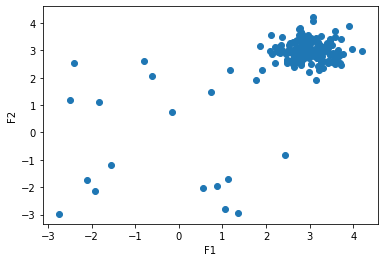

In [12]:
from pyod.utils.data import generate_data, get_outliers_inliers

#generate random data with two features
X_train, Y_train = generate_data(n_train=200,train_only=True, n_features=2)

# by default the outlier fraction is 0.1 in generate data function 
outlier_fraction = 0.1

# store outliers and inliers in different numpy arrays
x_outliers, x_inliers = get_outliers_inliers(X_train,Y_train)

n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

#separate the two features and use it to plot the data 
F1 = X_train[:,[0]].reshape(-1,1)
F2 = X_train[:,[1]].reshape(-1,1)


# create a meshgrid 
xx , yy = np.meshgrid((-10, 10, 200), np.linspace(-10, 10, 200))

# scatter plot 
plt.scatter(F1,F2)
plt.xlabel('F1')
plt.ylabel('F2') 

No of Errors :  K Nearest Neighbors (KNN) 2


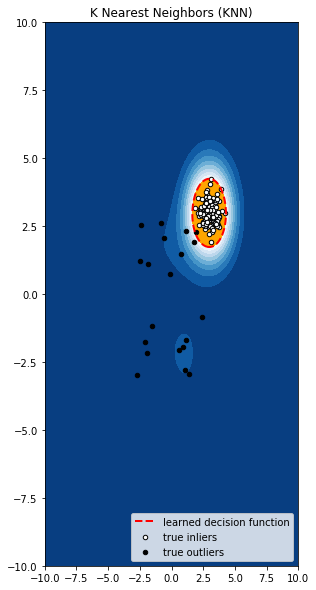

In [44]:
from pyod.models.ocsvm import OCSVM
from numpy import percentile

clf = OCSVM(contamination=outliers_fraction)

#set the figure size
plt.figure(figsize=(10, 10))

clf.fit(X_train)

# predict raw anomaly score
scores_pred = clf.decision_function(X_train)*-1

# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X_train)

# no of errors in prediction
n_errors = (y_pred != Y_train).sum()
print('No of Errors : ',clf_name, n_errors)

# rest of the code is to create the visualization

# threshold value to consider a datapoint inlier or outlier
threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)

# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

subplot = plt.subplot(1, 2, i + 1)

# fill blue colormap from minimum anomaly score to threshold value
subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)

# draw red contour line where anomaly score is equal to threshold
a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

# scatter plot of inliers with white dots
b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
# scatter plot of outliers with black dots
c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',s=20, edgecolor='k')
subplot.axis('tight')

subplot.legend(
    [a.collections[0], b, c],
    ['learned decision function', 'true inliers', 'true outliers'],
    prop=matplotlib.font_manager.FontProperties(size=10),
    loc='lower right')

subplot.set_title(clf_name)
subplot.set_xlim((-10, 10))
subplot.set_ylim((-10, 10))
plt.show() 

In [13]:
classifiers = {
     'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),
     'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction)
}

No of Errors :  Angle-based Outlier Detector (ABOD) 8
No of Errors :  K Nearest Neighbors (KNN) 1


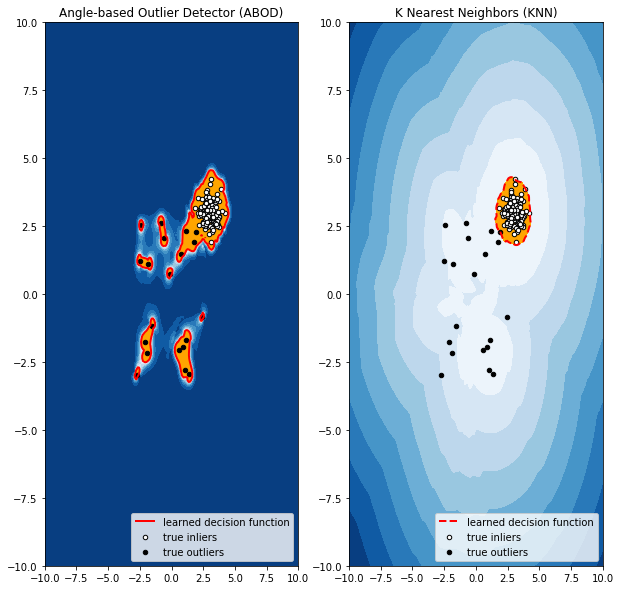

In [14]:
#set the figure size
plt.figure(figsize=(10, 10))

for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X_train)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train)

    # no of errors in prediction
    n_errors = (y_pred != Y_train).sum()
    print('No of Errors : ',clf_name, n_errors)

    # rest of the code is to create the visualization

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, 2, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
    b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
    # scatter plot of outliers with black dots
    c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',s=20, edgecolor='k')
    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')

    subplot.set_title(clf_name)
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.show() 